In [ ]:
pip install liesel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 9.2 MB/s eta 0:00:00


In [ ]:
# This cell installs the necessary packages.
# Afterwards, you need to restart the sessions.
!apt install libgraphviz-dev # necessary here for successful pygraphviz installation
!pip install pygraphviz liesel # install pygraphviz (for plotting model graphs nicely) and liesel

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [ ]:
import jax
import jax.numpy as jnp
import liesel.model as lsl
import liesel.goose as gs
import liesel.contrib.splines as splines
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import numpy as np
import plotnine as p9
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import plotnine as p9

In [ ]:
from liesel.contrib.splines import equidistant_knots, basis_matrix
import tensorflow_probability.substrates.jax.bijectors as tfb
from liesel.distributions.mvn_degen import MultivariateNormalDegenerate

In [ ]:
def generate_gaussian_data(n, M=3, c_u=0.0, seed=None):
    """
    Generate synthetic Gaussian-distributed data with replicates and a response variable.

    Args:
        n (int): The number of samples.
        M (int, optional): The number of replicates per sample. Default is 3.
        c_u (float, optional): The covariance factor between replicates. Default is 0.0.
        seed (int, optional): Random seed for reproducibility. Default is None.

    Returns:
        tuple: (y, x, replicates, sigma_matrices) as JAX arrays.
    """

    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Sample values for true covariate
    x = np.random.normal(loc=10, scale=5, size=n)

    # Generate covariance matrices
    def create_sigma_me(dim_sigma_me, c_u):
        Sigma_me = np.zeros((dim_sigma_me, dim_sigma_me))
        for i in range(dim_sigma_me):
            for j in range(dim_sigma_me):
                if i == j:
                    Sigma_me[i, j] = 1
                else:
                    Sigma_me[i, j] = c_u
        return Sigma_me

    # Scale the Sigma_me matrices by individual variance factor
    sigma_matrices = []
    for i in range(n):
        sigma_sq_ui = 1 if i < n // 2 else 2  # First half scaled by 1, second half by 2
        Sigma_me = create_sigma_me(M, c_u)
        scaled_matrix = sigma_sq_ui * Sigma_me
        sigma_matrices.append(scaled_matrix)

    sigma_matrices_array = jnp.array(np.stack(sigma_matrices))

    # Create M replicates of true variable x
    replicates = []
    for i in range(n):
        mean_vector = np.repeat(x[i], M)
        Sigma_me = sigma_matrices[i]
        samples = np.random.multivariate_normal(mean_vector, Sigma_me)
        replicates.append(samples)

    # Generate response variable y
    variances = np.random.choice([0.3, 0.5], size=n)
    y = np.random.normal(loc=np.sin(x), scale=np.sqrt(variances))

    # Convert to JAX arrays before returning
    x = jnp.array(x)
    replicates = jnp.array(np.array(replicates))
    y = jnp.array(y)
    sigma_matrices = jnp.array(np.stack(sigma_matrices))

    return y, x, replicates, sigma_matrices


In [ ]:
# Define the number of samples and replicates
n = 500  # Number of data points
M = 3    # Number of replicates per sample

# Generate synthetic Gaussian data
y, x, x_tilde, sigma_matrices = generate_gaussian_data(n = n, M = M, c_u=0.25, seed=42)

# Print the shapes of the generated data
print(f"Shape of sigma_matrices_array: {sigma_matrices.shape}")
print(f"Shape of x: {x.shape}")
print(f"Shape of replicates: {x_tilde.shape}")
print(f"Shape of response: {y.shape}")

Shape of sigma_matrices_array: (500, 3, 3)
Shape of x: (500,)
Shape of replicates: (500, 3)
Shape of response: (500,)


In [ ]:
# Look a covariance structure of replicates
sigma_matrices[0]

Array([[1.  , 0.25, 0.25],
       [0.25, 1.  , 0.25],
       [0.25, 0.25, 1.  ]], dtype=float32)

In [ ]:
# Define Number of knots/spline parameters to use
n_param_splines = 20

In [ ]:
# Define hyperparameters for variance of x
a_x = lsl.Var.new_param(0.001, name = "a_x")
b_x = lsl.Var.new_param(0.001, name = "b_x")

# Define prior for tau2_x using an Inverse Gamma distribution
tau2_x_prior = lsl.Dist(tfd.InverseGamma, concentration = a_x, scale = b_x)
tau2_x = lsl.Var.new_param(10.0, distribution = tau2_x_prior, name = "tau2_x")
# tau2_x.transform(bijector=tfb.Exp())

# Define hyperparameters for mu_x (mean of x)
location_mu_x_prior = lsl.Var.new_param(0.0, name = "location_mu_x_prior")
scale_mu_x_prior = lsl.Var.new_param(1000.0, name= "scale_mu_x_prior")
#scale_mu_x_prior.transform(bijector = tfb.Exp())

# Define prior for mu_x using a Normal distribution
mu_x_prior = lsl.Dist(tfd.Normal, loc = location_mu_x_prior, scale = scale_mu_x_prior)

# Define mu_x as a parameter with the prior distribution
mu_x= lsl.Var.new_param(0.0, distribution = mu_x_prior, name = "mu_x")

# Define prior distribution for x
x_prior_dist = lsl.Dist(tfd.Normal, loc = mu_x, scale = tau2_x)

# Estimate x using the mean of replicates and assign a prior distribution
x_estimated = lsl.Var.new_param(jnp.expand_dims(x_tilde.mean(axis=1), -1), # initial estimation is the mean of the replicates
                                distribution = x_prior_dist,
                                name="x_estimated")
# Create Distribution for measuremnt errors
measurement_dist = lsl.Dist(
    tfd.MultivariateNormalFullCovariance,
    loc=x_estimated,
    covariance_matrix=sigma_matrices,
)

# Define x_tilde (observed replicates) as observed data in the probabilistic model
x_tilde_var = lsl.Var.new_obs(
    value = x_tilde,
    distribution=measurement_dist,
    name="x_tilde"
)

In [ ]:
# Generate equidistant knots for spline basis functions based on the mean of replicates (x_tilde)
knots = equidistant_knots(jnp.expand_dims(x_tilde.mean(axis=1), -1), n_param=n_param_splines, order=3)

# Compute spline basis matrix for modeling the mean function
basis_matrix_var_mu = lsl.Var.new_calc(
    lambda x: splines.basis_matrix(
        x.squeeze(),
        knots=knots,    # Use precomputed knots
        order=3,        # Cubic spline basis
        outer_ok=True),
    x = x_estimated,
    name="basis_matrix_mu"
)

# Compute spline basis matrix for modeling the scale
basis_matrix_var_scale = lsl.Var.new_calc(
    lambda x: splines.basis_matrix(
        x.squeeze(),
        knots=knots,
        order=3,
        outer_ok=True),
    x = x_estimated,
    name="basis_matrix_scale"
)

# Define intercept parameters for the mean and scale functions in the spline model
b0_mu = lsl.Var.new_param(0.0, name="b0_mu")
b0_scale = lsl.Var.new_param(0.0, name="b0_scale")

In [ ]:
# Define hyperparameters for the variance of the mean function
a_var_mu = lsl.Var.new_param(0.001, name = "a_mu")
b_var_mu = lsl.Var.new_param(0.001, name = "b_mu")

# Define hyperparameters for the variance of the scale function
a_var_scale = lsl.Var.new_param(0.001, name = "a_scale")
b_var_scale = lsl.Var.new_param(0.001, name = "b_scale")

# Define prior tau2_mu distributions using Inverse Gamma
prior_tau2_mu = lsl.Dist(tfd.InverseGamma, concentration=a_var_mu, scale=b_var_mu)
tau2_mu = lsl.param(10.0, distribution = prior_tau2_mu, name= "tau2_mu")
#tau2_mu.transform(bijector=tfb.Exp())

# Define prior tau2_scale distributions using Inverse Gamma
prior_tau2_scale = lsl.Dist(tfd.InverseGamma, concentration = a_var_scale, scale = b_var_scale)
tau2_scale = lsl.param(10.0, distribution = prior_tau2_scale, name= "tau_scale")
#tau2_scale.transform(bijector=tfb.Exp())

/usr/local/lib/python3.11/dist-packages/liesel/model/nodes.py:2535: FutureWarning: Use lsl.Var.new_param() instead. This function will be removed in v0.4.0


In [ ]:
# Compute P-spline penalty matrix (2nd-order difference for smoothness)
penalty = splines.pspline_penalty(d=n_param_splines,diff=2)

# Define penalty matrices for scale and mean functions
penalty_scale = lsl.Var.new_param(penalty, name= "penalty_scale")
penalty_mu = lsl.Var.new_param(penalty, name= "penalty_mu")

# Compute eigenvalues of the penalty matrix
evals = jax.numpy.linalg.eigvalsh(penalty)

# Compute rank of the penalty matrix (number of positive eigenvalues)
rank_scale = lsl.Value(jnp.sum(evals > 0.0), _name= "rank_scale")
rank_mu = lsl.Value(jnp.sum(evals > 0.0), _name= "rank_mu")

# Compute log determinant of the penalty matrix (ignoring zero eigenvalues)
log_pdet = jnp.log(jnp.where(evals > 0.0, evals, 1.0)).sum()
log_pdet_mu = lsl.Value(log_pdet, _name= "log_pdet_mu")
log_pdet_scale = lsl.Value(log_pdet, _name= "log_pdet_scale")

# Define prior distribution for spline coefficients (scale function)
prior_coef_scale  = lsl.Dist(
    MultivariateNormalDegenerate.from_penalty,
    loc= jnp.zeros(shape=(n_param_splines,)),
    var= tau2_scale,
    pen= penalty_scale,
    rank = rank_scale,
    log_pdet=log_pdet_scale
    )

# Initialize spline coefficients for scale function
start_value_scale = np.zeros(np.shape(penalty)[-1], np.float32)
coef_scale = lsl.param(start_value_scale, distribution= prior_coef_scale, name= "coef_scale")

# Define prior distribution for spline coefficients (mean function)
prior_coef_mu  = lsl.Dist(
    MultivariateNormalDegenerate.from_penalty,
    loc= jnp.zeros(shape=(n_param_splines,)),
    var=tau2_mu,
    pen= penalty_mu,
    rank = rank_mu,
    log_pdet=log_pdet_mu
    )

# Initialize spline coefficients for mean function
start_value_mu = np.zeros(np.shape(penalty)[-1], np.float32)
coef_mu = lsl.param(start_value_mu, distribution= prior_coef_mu, name= "coef_mu")

In [ ]:
# Predictive function for the spline model
# Computes the linear predictor: intercept + basis function expansion
def pred_fn(beta0, spline_coef, basis_matrix):
    return beta0 + jnp.dot(basis_matrix, spline_coef)

In [ ]:
# Define prior hyperparameters for sigma2 (variance)
a_var = lsl.Var.new_value(0.01, name="a")
b_var = lsl.Var.new_value(0.01, name="b")

# Define Inverse Gamma prior for sigma²
sigma2_prior = lsl.Dist(tfd.InverseGamma, concentration=a_var, scale=b_var)

# Define sigma2 as a model parameter with the specified prior
sigma2_var = lsl.Var.new_param(1.0, sigma2_prior, name="sigma2")

# Compute sigma (standard deviation) as the square root of sigma2
sigma_var = lsl.Var.new_calc(jnp.sqrt, sigma2_var, name="sigma")

# Ensure sigma2 remains positive by applying an exponential transformation
sigma2_var.transform(bijector = tfb.Exp())

Var(name="sigma2_transformed")

In [ ]:
# Compute the scale (standard deviation) of y using the spline model
scale_of_y = lsl.Var.new_calc(
    pred_fn,
    beta0=b0_scale,                       # Intercept for scale function
    spline_coef=coef_scale,               # Spline coefficients for scale
    basis_matrix=basis_matrix_var_scale,  # Basis matrix for scale
    name="scale_of_y"
)

# Transform scale_of_y to ensure positivity (exponential transformation)
scale_of_y_transformed = lsl.Var.new_calc(jnp.exp, scale_of_y, name = "scale_of_y_transformed")
#scale_of_y_transformed.transform(bijector = tfb.Exp())

# Compute the mean (mu) of y using the spline model
mu_of_y = lsl.Var.new_calc(
    pred_fn,
    beta0= b0_mu,
    spline_coef = coef_mu,
    basis_matrix = basis_matrix_var_mu,
    name="mu_of_y"
)

# Define the likelihood distribution of y (Normal with estimated mean and scale)
y_dist = lsl.Dist(
    tfd.Normal,
    loc=mu_of_y,
    scale= scale_of_y_transformed
  )

# Define y as an observed variable with the specified distribution
y_var = lsl.Var.new_obs(
    value=y,
    distribution=y_dist,
    name="y"
)

In [ ]:
# create joint model for x and y
model = lsl.Model([y_var, x_tilde_var])

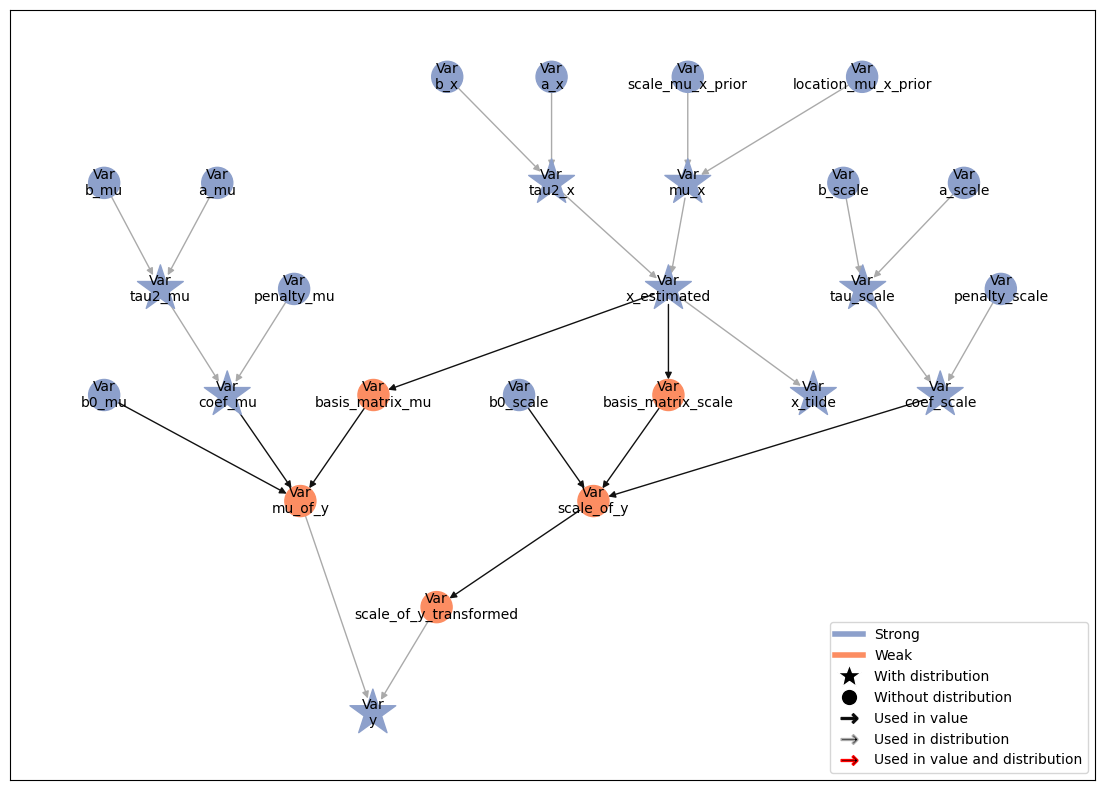

In [ ]:
# Plot tree
model.plot_vars()

In [ ]:
def transition_tau_mu(prng_key, model_state):
    """
    Sample tau2_mu from its posterior distribution using Gibbs sampling.

    Args:
        prng_key: The random number generator key for sampling.
        model_state: A dictionary containing the model parameters and state.

    Returns:
        dict: A dictionary containing the sampled tau2_mu.
    """
    # Extract relevant parameters from model state
    pos = interface.extract_position(
        position_keys=["a_mu", "b_mu", "rank_mu", "penalty_mu", "coef_mu"],
        model_state=model_state
    )
    # Extract values from position
    a_prior = pos["a_mu"]
    b_prior = pos["b_mu"]
    rank = pos["rank_mu"]
    K = pos["penalty_mu"]
    beta = pos["coef_mu"]

    # Compute the Gibbs sampling parameters
    a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
    b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

    # Draw a sample from the gamma distribution
    draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

    return {"tau2_mu": draw}


def transition_tau_scale(prng_key, model_state):
    """
    Sample tau_scale from its posterior distribution using Gibbs sampling.

    Args:
        prng_key: The random number generator key for sampling.
        model_state: A dictionary containing the model parameters and state.

    Returns:
        dict: A dictionary containing the sampled tau_scale.
    """
    # Extract relevant parameters from model state
    pos = interface.extract_position(
        position_keys=["a_scale", "b_scale", "rank_scale", "penalty_scale", "coef_scale"],
        model_state=model_state
    )
    # Extract values from position
    a_prior = pos["a_scale"]
    b_prior = pos["b_scale"]
    rank = pos["rank_scale"]
    K = pos["penalty_scale"]
    beta = pos["coef_scale"]

    # Compute the Gibbs sampling parameters
    a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
    b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

    # Draw a sample from the gamma distribution
    draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

    return {"tau_scale" : draw}

def transition_mu_x(prng_key, model_state):
    """
    Sample mu_x from its posterior distribution conditioned on the data.

    Args:
        prng_key: The random number generator key for sampling.
        model_state: A dictionary containing the model parameters and state.

    Returns:
        dict: A dictionary containing the sampled mu_x.
    """
    # Extract relevant parameters from model state
    pos = interface.extract_position(
        position_keys=["x_estimated", "tau2_mu", "tau2_x", "a_x", "b_x"],
        model_state=model_state
    )
    x = pos["x_estimated"]
    n = len(x)
    tau2_mu = pos["tau2_mu"]
    tau2_x = pos["tau2_x"]
    a_x = pos["a_x"]
    b_x = pos["b_x"]

    # Compute the posterior mean and standard deviation for mu_x
    normal_sample = jax.random.normal(prng_key, (1,))
    mu_mean = (n * jnp.mean(x) * tau2_mu) / (n * tau2_mu + tau2_x)
    mu_std = jnp.sqrt(tau2_x * tau2_mu / (n * tau2_mu + tau2_x))

    # Sample mu_x from a normal distribution
    mu_x = jnp.squeeze(mu_mean + mu_std * normal_sample)

    return {"mu_x": mu_x}


def transition_tau2_x(prng_key, model_state):
    """
    Sample tau2_x from its posterior distribution using the inverse gamma distribution.

    Args:
        prng_key: The random number generator key for sampling.
        model_state: A dictionary containing the model parameters and state.

    Returns:
        dict: A dictionary containing the sampled tau2_x.
    """
    # Extract relevant parameters from model state
    pos = interface.extract_position(
        position_keys=["a_x", "b_x", "x_estimated", "mu_x", "b_x"],
        model_state=model_state
    )
    a_x = pos["a_x"]
    b_x = pos["b_x"]
    x = pos["x_estimated"]
    n = len(x)
    mu_x = pos["mu_x"]

    # Compute the new alpha and beta for the inverse gamma distribution
    alpha_new = a_x + n / 2
    beta_new = b_x + ((x - mu_x)**2).sum() / 2

    # Sample tau2_x from the inverse gamma distribution
    tau2_x = jnp.squeeze(tfd.InverseGamma(concentration=alpha_new, scale=beta_new).sample(seed=prng_key))

    return {"tau2_x" : tau2_x}


def x_proposal(key, model_state, step_size):
    """
    Propose a new value for x using a Metropolis-Hastings proposal distribution.

    Args:
        key: The random number generator key for sampling.
        model_state: A dictionary containing the model parameters and state.
        step_size: A scaling factor for the proposal distribution.

    Returns:
        gs.MHProposal: A Metropolis-Hastings proposal object containing the proposed x values and the log correction.
    """
    # Extract current values of x_estimated and x_tilde from model state
    pos = interface.extract_position(
        position_keys=["x_estimated", "x_tilde"],
        model_state=model_state
    )
    x_current = pos["x_estimated"].squeeze()  # Turn from (n, 1) into (n,)
    n, m = pos["x_tilde"].shape

    # Initialize the step size scaling factor and covariance matrix
    g = 1.0
    M = m
    eye_matrices = jnp.eye(m, dtype=jnp.float32)

    # Create a stack of identity matrices and draw normal samples
    sigma = jnp.stack([eye_matrices for _ in range(n)])  # (n, m, m)
    normal_samples = jax.random.normal(key, (n,))  # (n,)

    # Compute the scale factor for the proposal
    trace_values = jnp.trace(sigma, axis1=1, axis2=2)  # (n,)
    scale_factor = (g * trace_values / (M**2))  # (n,)

    # Propose new x values
    x_proposed = x_current + scale_factor * normal_samples * step_size  # (n,)
    pos = {"x_estimated": jnp.expand_dims(x_proposed, -1)}  # Turn back into (n, 1)

    return gs.MHProposal(pos, log_correction=0.0)

In [ ]:
interface = gs.LieselInterface(model)

In [ ]:
# Initialize engine
eb = gs.EngineBuilder(seed=1, num_chains=4)

# Set the model and initial values
eb.set_model(gs.LieselInterface(model))
eb.set_initial_values(model.state)

# Add sampling kernels
eb.add_kernel(gs.IWLSKernel(["coef_scale"]))
eb.add_kernel(gs.IWLSKernel(["coef_mu"]))
eb.add_kernel(gs.RWKernel(["x_estimated"]))
eb.add_kernel(gs.GibbsKernel(["tau2_mu"], transition_tau_mu))
eb.add_kernel(gs.GibbsKernel(["mu_x"], transition_mu_x))
eb.add_kernel(gs.GibbsKernel(["tau_scale"], transition_tau_scale))
eb.add_kernel(gs.GibbsKernel(["tau2_x"], transition_tau2_x))

# Alternative Metropolis-Hastings Kernel for x (commented due to proposal issues), needs fix
# eb.add_kernel(gs.MHKernel(["x_estimated"], x_proposal))

# Set MCMC durations: warmup, sampling, and thinning
eb.set_duration(warmup_duration=1000, posterior_duration=5000, thinning_posterior=10)

# Include mean and scale
eb.positions_included = ["mu_of_y", "scale_of_y_transformed"]

# Build the sampling engine
engine = eb.build()


liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [ ]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:55<00:00, 18.39s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 152.86chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 181.87chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
100%|█████████████████████████████████████████| 4/4 [00:00<00:00, 200.83chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 100 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engin

In [ ]:
results = engine.get_results()
summary = gs.Summary(results)

In [ ]:
gs.Summary(results)

In [ ]:
# Plot the treace of all scale coefficients
gs.plot_trace(results, "coef_scale")

In [ ]:
# Plot the treace of all location coefficients
gs.plot_trace(results, "coef_mu")

In [ ]:

gs.plot_param(results, "tau2_mu")

In [ ]:
gs.plot_param(results, "mu_x")

In [ ]:
gs.plot_param(results, "tau_scale")

In [ ]:
gs.plot_param(results, "tau2_x")

In [ ]:
# Get estimates of x
x_estimated_mean = summary.quantities["mean"]["x_estimated"]

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))

# Plot histogram for x_true
sns.histplot(x, bins=25, kde=True, color='r', alpha=0.6, label="x_true")

# Plot histogram for x_estimated_mean
sns.histplot(x_estimated_mean, bins=25, kde=True, color='b', alpha=0.6, label="x_estimated")

# Add title and labels
plt.title("True x vs. Estimated x")
plt.xlabel("Value")
plt.ylabel("Density")

# Show legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Retrieve posterior samples
samples = results.get_posterior_samples()

# Compute mean posterior prediction
mu_mean = samples["mu_of_y"].mean(axis=(0, 1))

# Compute mean and 95% credible interval for scale (uncertainty)
sigma_mean = samples["scale_of_y_transformed"].mean(axis=(0, 1))
sigma_lo = jnp.quantile(samples["scale_of_y_transformed"], 0.025, axis=(0, 1))
sigma_hi = jnp.quantile(samples["scale_of_y_transformed"], 0.975, axis=(0, 1))

In [ ]:
# Get posterior samples for x
x_posterior_samples = samples["x_estimated"]

# Compute posterior mean of x
x_posterior_mean = x_posterior_samples.mean(axis=(0, 1)).squeeze()

# Compute basis matrix at posterior mean of x
basis_matrix_post_mean = basis_matrix_var_mu.value_node.function(x_posterior_mean)

# Compute posterior mean of regression coefficients
coef_mu_post = samples["coef_mu"].mean(axis=(0, 1))

# Compute posterior mean function estimate
posterior_mean_function = basis_matrix_post_mean @ coef_mu_post

In [ ]:
coef_mu_post

In [ ]:
# Define x input for plot functions
input_var = x_posterior_mean

In [ ]:
(
    p9.ggplot()
    + p9.aes(input_var, y)
    + p9.geom_point(alpha=0.2)
    + p9.geom_line(p9.aes(input_var, posterior_mean_function), color="blue", size=2)
    + p9.geom_ribbon(p9.aes(input_var, ymin=mu_mean - sigma_mean, ymax=mu_mean + sigma_mean), fill="blue", size=2, alpha=0.3)
    + p9.labs(title="Posterior location and scale functions")
)

In [ ]:
# Define a smooth range for x using the min/max of your input array
x_smooth = np.linspace(input_var.min(), input_var.max(), 300)
sin_x = np.sin(x_smooth)

# Create a new dataframe for sin(x)
df_sin = pd.DataFrame({"input_var": x_smooth, "sin_x": sin_x})

(
    p9.ggplot()
    + p9.aes("input_var", "y")  # Keep aesthetics for consistency
    + p9.geom_point(alpha=0.2)
    + p9.geom_line(p9.aes("input_var", "posterior_mean_function"), color="blue", size=2)
    + p9.geom_ribbon(
        p9.aes("input_var", ymin="mu_mean - sigma_mean", ymax="mu_mean + sigma_mean"),
        fill="blue",
        size=2,
        alpha=0.3,
    )
    + p9.geom_line(df_sin, p9.aes("input_var", "sin_x"), color="red", size=1, linetype="dashed")  # sin(x) curve
    + p9.labs(title="Posterior location and scale functions with sin(x)")
)

In [ ]:
(
    p9.ggplot()
    + p9.geom_line(p9.aes(input_var, sigma_mean), color="red", size=2)
    + p9.geom_ribbon(p9.aes(input_var, ymin=sigma_lo, ymax=sigma_hi), fill="red", size=2, alpha=0.3)
    + p9.labs(title="Posterior uncertainty in the scale function")
)